In [1]:
import pandas as pd
import pyarrow.parquet as pq
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.fftpack import fft, ifft
import scipy.integrate as integrate

from tqdm import trange
import gc
import seaborn as sns
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

from sklearn.model_selection import KFold
import lightgbm as lgb

/usr/local/opt/pyenv/versions/3.6.4/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
%%time
meta_train = pd.read_csv('input/metadata_train.csv')
subset_train = pq.read_pandas('input/train.parquet').to_pandas()

CPU times: user 1min 53s, sys: 52 s, total: 2min 45s
Wall time: 49.8 s


In [4]:
%%time
train_length = meta_train.shape[0]
positive_length = len(meta_train[meta_train.target == 1])

train_df = pd.DataFrame()
row_index = 0
for i in range(train_length):
    # downsampling
    if meta_train.loc[i,'target'] == 1 or random.random() < positive_length / train_length:
        subset_train_row = subset_train[str(i)]
        train_df.loc[row_index, 'signal_min'] = subset_train_row.min()
        train_df.loc[row_index, 'signal_max'] = subset_train_row.max()
        train_df.loc[row_index, 'signal_mean'] = subset_train_row.mean()
        train_df.loc[row_index, 'signal_std'] = subset_train_row.std()
        
        ffT = np.fft.ifft(subset_train_row, n = 30000)[5:30000].real
        
        train_df.loc[row_index, 'FTs_max'] = ffT.max()
        train_df.loc[row_index, 'FTs_integral'] = abs(ffT).sum()
        train_df.loc[row_index, 'FTs_std'] = ffT.std()
        
        # *** Add your feature here ***
        train_df.loc[row_index, 'signal_id'] = i
        row_index += 1
print("positive length: " + str(positive_length))
# positive length 525
print("train length: " + str(len(train_df)))
# train length 1038  example
# This will be about 1050

train_df = pd.merge(train_df, meta_train, on='signal_id')
train_df.to_csv("train.csv", index=False)
train_df.head()

positive length: 525
train length: 1028
CPU times: user 40.1 s, sys: 6.4 s, total: 46.5 s
Wall time: 50.6 s


In [5]:
x_train = train_df.copy()
target = x_train['target']
input_target = x_train['target']
x_train.drop(['target', 'signal_id'], axis=1, inplace=True)
features = x_train.columns
param = {'num_leaves': 90,
         'min_data_in_leaf': 80, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 2,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 164,
         "verbosity": -1}
max_iter=5


In [12]:
folds = KFold(n_splits=6, shuffle=True, random_state=19)
oof = np.zeros(len(x_train))
feature_importance_df = pd.DataFrame()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, target.values)):
    print("Fold No.{}".format(fold_+1))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx])
    val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                           label=target.iloc[val_idx])
    num_round = 15000
    print(x_train.iloc[trn_idx][features].shape)
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 300)
    
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        
if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

Fold No.1
(856, 9)
Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.938769	valid_1's auc: 0.866928
[200]	training's auc: 0.961582	valid_1's auc: 0.879653
[300]	training's auc: 0.975326	valid_1's auc: 0.881955
[400]	training's auc: 0.983731	valid_1's auc: 0.883715
[500]	training's auc: 0.989655	valid_1's auc: 0.886828
[600]	training's auc: 0.99348	valid_1's auc: 0.890619
[700]	training's auc: 0.9963	valid_1's auc: 0.891566
[800]	training's auc: 0.997656	valid_1's auc: 0.889265
[900]	training's auc: 0.998596	valid_1's auc: 0.892514
Early stopping, best iteration is:
[664]	training's auc: 0.99541	valid_1's auc: 0.893191
Fold No.2
(856, 9)
Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.937976	valid_1's auc: 0.844119
[200]	training's auc: 0.962058	valid_1's auc: 0.854837
[300]	training's auc: 0.977068	valid_1's auc: 0.852937
[400]	training's auc: 0.985454	valid_1's auc: 0.855786
[500]	training's auc: 0.991177	vali

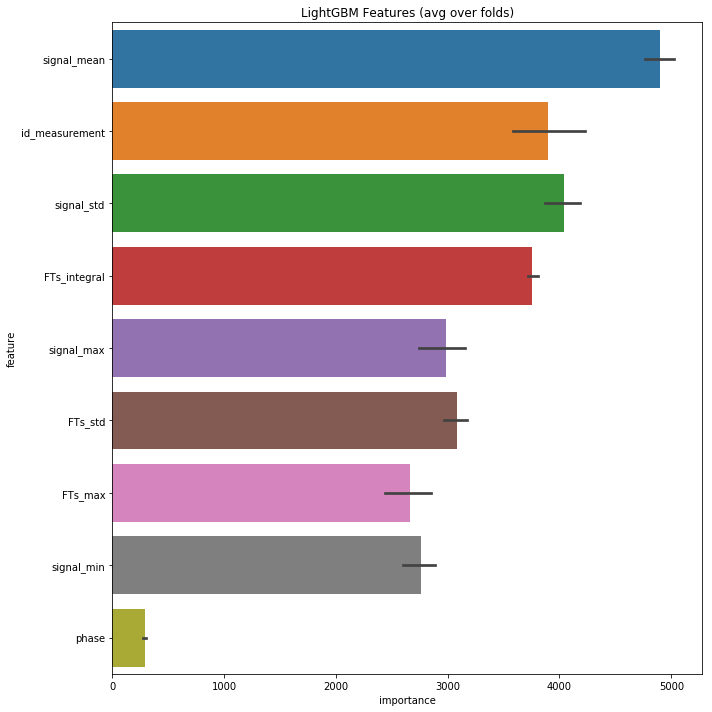

In [106]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [107]:
gc.collect()

3182

# Predict and Submit

In [108]:
%%time
# 25ms in Kernel
meta_test = pd.read_csv('input/metadata_test.csv')

CPU times: user 8.3 ms, sys: 3.89 ms, total: 12.2 ms
Wall time: 11 ms


In [109]:
%%time
meta_test = pd.read_csv('input/metadata_test.csv')
subset_test = pq.read_pandas('input/test.parquet').to_pandas()

CPU times: user 4min 23s, sys: 2min 3s, total: 6min 26s
Wall time: 2min 19s


In [110]:
test_length = meta_test.shape[0]

test_df = pd.DataFrame()
row_index = 0
for i in trange(test_length):
#     import pdb; pdb.set_trace()
    subset_test_row = subset_test[str(i+8712)]
    test_df.loc[row_index, 'signal_min'] = subset_test_row.min()
    test_df.loc[row_index, 'signal_max'] = subset_test_row.max()
    test_df.loc[row_index, 'signal_mean'] = subset_test_row.mean()
    test_df.loc[row_index, 'signal_std'] = subset_test_row.std()

    ffT = np.fft.ifft(subset_test_row, n = 30000)[5:30000].real

    test_df.loc[row_index, 'FTs_max'] = ffT.max()
    test_df.loc[row_index, 'FTs_integral'] = abs(ffT).sum()
    test_df.loc[row_index, 'FTs_std'] = ffT.std()

    # *** Add your feature here ***
    test_df.loc[row_index, 'signal_id'] = i + 8712
    row_index += 1
print("test length: " + str(len(test_df)))

100%|██████████| 20337/20337 [14:08<00:00, 23.97it/s]

test length: 20337


In [111]:
test_length, test_df.shape

(20337, (20337, 8))

In [112]:
test_df = pd.merge(test_df, meta_test, on='signal_id')
test_df.to_csv("test.csv", index=False)

test_df.head()

,signal_min,signal_max,signal_mean,signal_std,FTs_max,FTs_integral,FTs_std,signal_id,id_measurement,phase
0,-46.0,28.0,-1.007639,13.805535,0.142591,50.038615,0.003732,8712.0,2904,0
1,-25.0,30.0,-0.178762,13.972893,0.150429,48.296124,0.003450,8713.0,2904,1
2,-27.0,31.0,-0.031567,13.806489,0.212504,50.801163,0.003768,8714.0,2904,2
3,-29.0,28.0,-0.021024,14.098745,0.225039,51.718029,0.006919,8715.0,2905,0
4,-35.0,29.0,-1.479971,13.573268,0.181641,52.244214,0.005958,8716.0,2905,1


In [113]:
x_test = test_df
x_filename = x_test['signal_id']
x_test = x_test.drop('signal_id', axis=1)

predictions = clf.predict(x_test, num_iteration=clf.best_iteration)

sub_df = pd.DataFrame({"signal_id":x_filename.values})
sub_df["target"] = pd.Series(predictions).round()
sub_df['signal_id'] = sub_df['signal_id'].astype(np.int64)
sub_df['target'] = sub_df['target'].astype(np.int64)
sub_df.to_csv("submission_three.csv", index=False)
sub_df

,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0
5,8717,0
6,8718,0
7,8719,0
8,8720,0
9,8721,0


In [114]:
positive = len(sub_df[sub_df["target"] == 1])
print(positive)
print(str(positive/len(sub_df)*100) + "%")

129
0.6343118454049269%


# Demonstrations

In [9]:
def show_shit(num_ = None):
    if not num_:
        num_ = np.random.randint(0,dataset.shape[0])
    print('Plot number: {}. Condition: {}'.format(num_, meta_.target.iloc[num_]))
    plt.figure(figsize=(15, 6))
    slic = dataset[num_]
    plt.plot(slic, label='Phase 0')
    print('Max: {}, min: {}, std deviation: {}, agv: {}'.format(slic.max(), slic.min(), slic.std(), slic.mean()))
    plt.legend()
    plt.show()

Plot number: 54. Condition: 0
Max: 34, min: -36, std deviation: 14.39839243907713, agv: -1.00969125


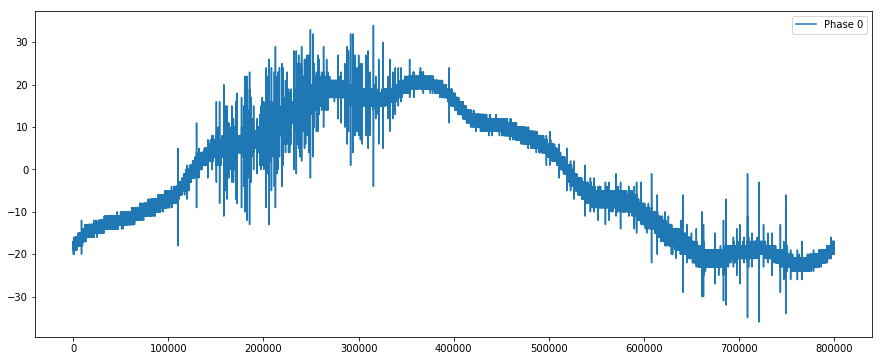

In [14]:
show_shit()